## 0. Import Libraries/Modules

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import cv2

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision.datasets import ImageFolder
import torchvision.transforms as transforms
import torchvision.models as models
from torch.utils.data.dataloader import DataLoader
from torchvision.utils import make_grid
from torch.utils.data import random_split

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')  # access google drive for saving model later

Mounted at /content/gdrive


In [3]:
! mkdir /content/gdrive/MyDrive/PIC16B/

mkdir: cannot create directory ‘/content/gdrive/MyDrive/PIC16B/’: File exists


In [4]:
PATH = "/content/gdrive/MyDrive/PIC16B/"

In [5]:
!pip install einops
!pip3 install --upgrade gdown --quiet
!gdown 1tHHD_wkOREgBSYpC0DqPeKIktx9G3P5X

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.6/41.6 KB 5.7 MB/s eta 0:00:00
Downloading...
From: https://drive.google.com/uc?id=1tHHD_wkOREgBSYpC0DqPeKIktx9G3P5X
To: /content/data.tar.gz
100% 62.7M/62.7M [00:01<00:00, 34.2MB/s]


In [6]:
import tarfile
from tqdm import tqdm

data_path = './'
os.makedirs(os.path.join(data_path, 'Project', 'data'), exist_ok=True)
root_dir = os.path.join(data_path, 'Project')


tar = tarfile.open("data.tar.gz", "r:gz")
total_size = sum(f.size for f in tar.getmembers())
with tqdm(total=total_size, unit="B", unit_scale=True, desc="Extracting tar.gz file") as pbar:
    for member in tar.getmembers():
        tar.extract(member, os.path.join(root_dir, 'data'))
        pbar.update(member.size)

# Close the tar.gz file
tar.close()

Extracting tar.gz file: 100%|██████████| 69.6M/69.6M [00:05<00:00, 12.8MB/s]


## 1. Data Exploration
### 1-1. Sample Images

In [7]:
root_dir = os.path.join(root_dir, 'data', 'images')
train_dir = os.path.join(root_dir, 'train')
test_dir = os.path.join(root_dir, 'test')

These are the facial expressions we're trying to detect

In [8]:
target_var = os.listdir(train_dir)
target_var

['happy', 'disgust', 'fear', 'surprise', 'angry', 'neutral', 'sad']

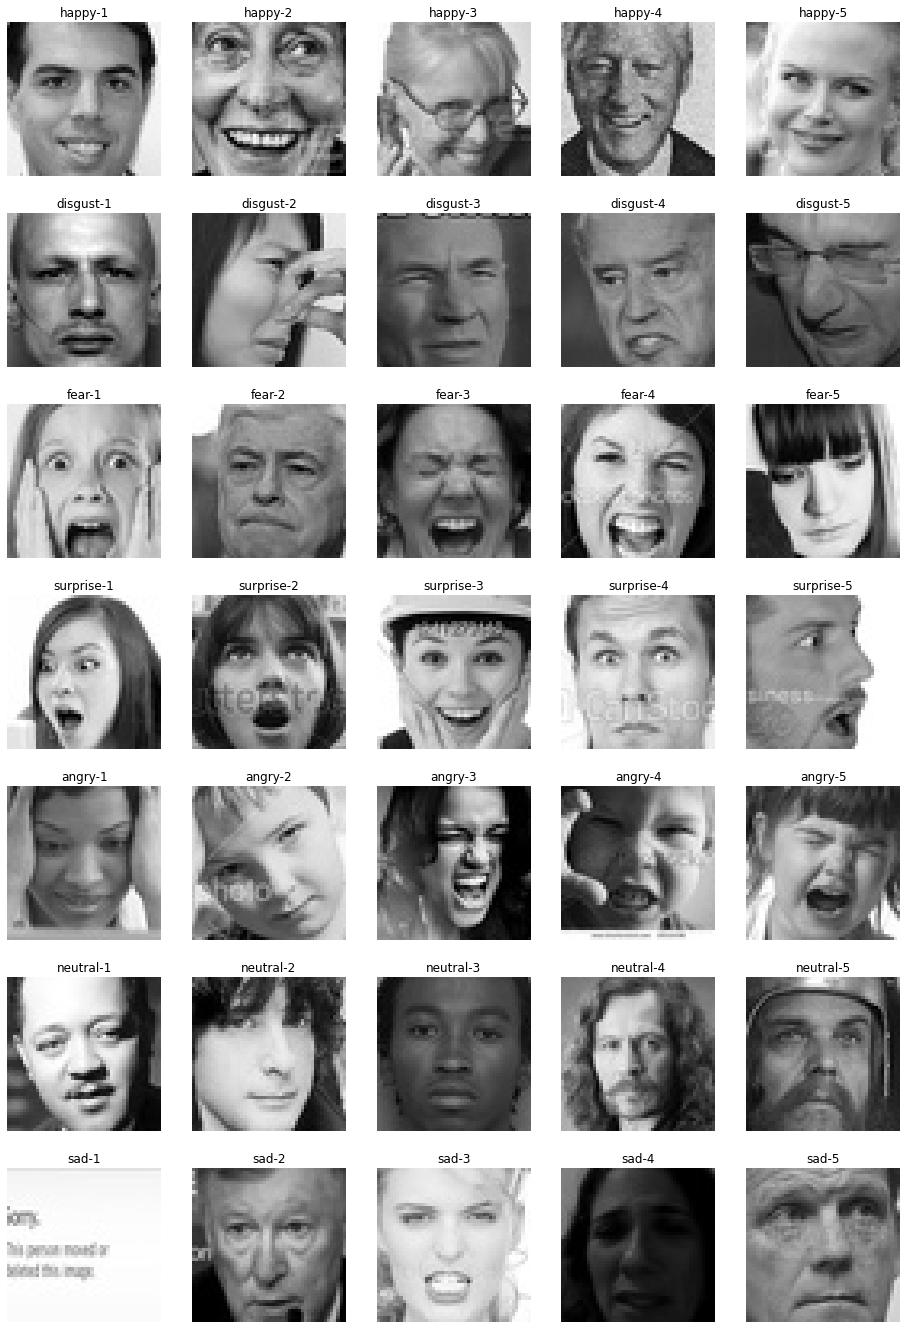

In [9]:
fig, axes = plt.subplots(7, 5, figsize=(16, 24))

for i in range(len(target_var)):
    for j in range(5):
        
        image = cv2.imread(os.path.join(train_dir, target_var[i], os.listdir(os.path.join(train_dir, target_var[i]))[j]))
        image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
        axes[i][j].imshow(image)
        axes[i][j].set_title(target_var[i] + "-" + str(j+1))
        axes[i][j].axis('off')
            
            
plt.axis('off')
plt.show()
        

### 1-2. Number of Images in Each Category

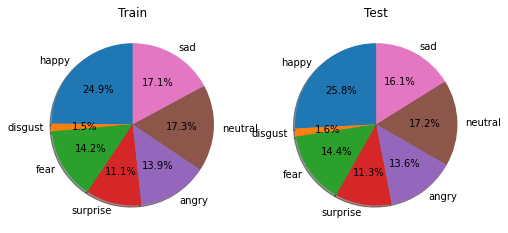

Emotion : happy
	Training : 7164
	 Testing : 1825
Emotion : disgust
	Training : 436
	 Testing : 111
Emotion : fear
	Training : 4103
	 Testing : 1018
Emotion : surprise
	Training : 3205
	 Testing : 797
Emotion : angry
	Training : 3994
	 Testing : 960
Emotion : neutral
	Training : 4982
	 Testing : 1216
Emotion : sad
	Training : 4938
	 Testing : 1139


In [10]:
x_train = np.array([ len(os.listdir(os.path.join(train_dir, i))) for i in target_var ])
x_test = np.array([ len(os.listdir(os.path.join(test_dir, i))) for i in target_var ])
label = target_var
  
fig, axes = plt.subplots(1, 2, figsize=(8,4))
axes[0].pie(x_train, labels=label, autopct='%1.1f%%',shadow=True, startangle=90)
axes[1].pie(x_test, labels=label, autopct='%1.1f%%',shadow=True, startangle=90)
axes[0].set_title('Train')
axes[1].set_title('Test')
plt.show()

for i in target_var:
    print('Emotion : ' + i )
    print('\tTraining : ' + str(len(os.listdir(os.path.join(train_dir, i)))) +'\n\t Testing : ' + str(len(os.listdir(os.path.join(test_dir, i)))))

### Define Data Transform

In [11]:
data_transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    
    # Normalize image using ImageNet statistics
    transforms.Normalize(mean=[0.485,0.456,0.406], std=[0.229,0.224,0.225])])

### Train, Validation Split

In [12]:
trainset = ImageFolder(train_dir, transform=data_transform)

val_size = int(len(trainset)/10)
train_size = len(trainset) - val_size

train_dataset, val_dataset = random_split(trainset, [train_size, val_size])
len(train_dataset), len(val_dataset)

(25939, 2882)

In [13]:
test_dataset = ImageFolder(test_dir, transform = data_transform)

### Define the Train Method

In [14]:
def train(model, train_loader, val_loader, optimizer, criterion, device, num_epochs):
    """
    Train the MLP classifier on the training set and evaluate it on the validation set every opch
    
    Args:
        model (MLP): MLP classifier to train.
        train_loader (torch.utils.data.DataLoader): Data loader for the training set.
        val_loader (torch.utils.data.DataLoader): Data loader for the validation set.
        optimizer (torch.optim.Optimizer): Optimizer to use for training.
        criterion (callable): Loss function to use for training.
        device (torch.device): Device to use for training.
        num_epochs (int): Number of epochs to train the model.
    """
    
    # Place model on device
    model = model.to(device)
    
    for epoch in range(num_epochs):
        model.train() # Set model to training mode
        
        # Use tqdm to displace a progress bar during training
        with tqdm(total=len(train_loader), desc=f'Epoch {epoch+1}/{num_epochs}') as pbar:
            for inputs, labels in train_loader:
                # Move inputs and labels to device
                inputs = inputs.to(device)
                labels = labels.to(device)
                
                # Zero out gradients
                optimizer.zero_grad()
                
                # Compute the logits and loss
                logits = model(inputs)
                loss = criterion(logits, labels)
                
                # Backpropagate the loss
                loss.backward()
                
                # Update the weights
                optimizer.step()
                
                # Update the progress bar
                pbar.update(1)
                pbar.set_postfix(loss=loss.item())
                
        # Evaluate the model on the validation set
        avg_loss, accuracy = evaluate(model, val_loader, criterion, device)
        print(f'Validation set: Average loss = {avg_loss:.4f}, Accuracy = {accuracy:.4f}')
        
def evaluate(model, test_loader, criterion, device):
    """
    Evaluate the MLP classifier on the test set.
    
    Args:
        model (MLP): MLP classifier to evaluate.
        test_loader (torch.utils.data.DataLoader): Data loader for the test set.
        criterion (callable): Loss function to use for evaluation.
        device (torch.device): Device to use for evaluation.
        
    Returns:
        float: Average loss on the test set.
        float: Accuracy on the test set.
    """
    model.eval()  # Set model to evaluation mode
    
    with torch.no_grad():
        total_loss = 0.0
        num_correct = 0
        num_samples = 0
        
        for inputs, labels in test_loader:
            # Move inputs and labels to device
            inputs = inputs.to(device)
            labels = labels.to(device)
            
            # Compute the logits and loss
            logits = model(inputs)
            loss = criterion(logits, labels)
            total_loss += loss.item()
            
            # Compute the accuracy
            _, predictions = torch.max(logits, dim=1)
            num_correct += (predictions == labels).sum().item()
            num_samples += len(inputs)
            
    # Compute the average loss and accuracy
    avg_loss = total_loss / len(test_loader)
    accuracy = num_correct / num_samples
    
    return avg_loss, accuracy

In [15]:
# Define the device to use for training
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
if device == torch.device('cuda'):
    print(f'Using device: {device}, Good to go!')
else:
    print('GPU not available')

Using device: cuda, Good to go!


In [16]:
!nvidia-smi

Tue Mar  7 18:49:54 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   67C    P0    30W /  70W |      3MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

### Build the ResNet

In [17]:
class Resnet(nn.Module):
    def __init__(self, mode='finetune', pretrained=True):
        super().__init__()
        """
        use the resnet18 model from torchvision models. Remember to set pretrained as true
        
        mode has two options:
        1) linear: For this mode, we want to freeze resnet18 feautres, then train a linear
                    classifier which takes the features before FC (again we do not want the resnet18 FC).
                    And then write our own FC layer: which takes in the features and 
                    output scores of size 7 (since we have 7 categories)
        2) finetune: Same as 1) linear, except that we do not need to freeze the features and
                    can finetune on the pretrained resnet model.
        """
        self.resnet = models.resnet50(pretrained=True)

        if mode == 'linear':
            for name, param in self.resnet.named_parameters():
                if param.requires_grad and 'fc' not in name:
                    param.requires_grad = False
            
            num_features = self.resnet.fc.in_features
            self.resnet.fc = nn.Linear(num_features, 7)

        elif mode == 'finetune':
            num_features = self.resnet.fc.in_features
            self.resnet.fc = nn.Linear(num_features, 7)

    def forward(self, x):
        x = self.resnet(x)
        return x

    def to(self, device):
        return self.resnet.to(device=device)


### Pretrained ResNet features + Linear Classifier

In [18]:
# Define the model, optimizer, and criterion
model = Resnet(mode='linear', pretrained=True)

optimizer = torch.optim.SGD(
    model.parameters(),
    lr=0.005,
    momentum=0.9
)

criterion = nn.CrossEntropyLoss()

# Define the batch size and number of workers
batch_size = 64
num_workers = 2

train_loader = DataLoader(train_dataset, batch_size, num_workers=num_workers, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size, num_workers=num_workers, shuffle=False)


model_name = "model.pt"
try:
  model.load_state_dict(torch.load(PATH + model_name))
  # continue training for more epochs:
  # train(model, train_loader, val_loader, optimizer, criterion, device, num_epochs=5)
except:
  train(model, train_loader, val_loader, optimizer, criterion, device, num_epochs=5)
torch.save(model.state_dict(), PATH + model_name)

/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

Epoch 1/5: 100%|██████████| 406/406 [00:52<00:00,  7.69it/s, loss=1.96]


Validation set: Average loss = 1.4939, Accuracy = 0.4539


Epoch 2/5: 100%|██████████| 406/406 [00:42<00:00,  9.52it/s, loss=1.1]


Validation set: Average loss = 1.5296, Accuracy = 0.4146


Epoch 3/5: 100%|██████████| 406/406 [00:37<00:00, 10.88it/s, loss=1.62]


Validation set: Average loss = 1.4308, Accuracy = 0.4587


Epoch 4/5: 100%|██████████| 406/406 [00:35<00:00, 11.38it/s, loss=1.59]


Validation set: Average loss = 1.4546, Accuracy = 0.4445


Epoch 5/5: 100%|██████████| 406/406 [00:37<00:00, 10.95it/s, loss=1.22]


Validation set: Average loss = 1.5444, Accuracy = 0.4039


### Finetune pretrained ResNet

#### Fully finetune with same learning rate

In [19]:
resnet_finetune1 = Resnet(mode='finetune', pretrained=True)

optimizer = torch.optim.SGD(
    resnet_finetune1.parameters(),
    lr = 0.01,
    momentum=0.9
)

criterion = nn.CrossEntropyLoss()

batch_size = 64
num_workers = 2

train_loader = DataLoader(train_dataset, batch_size, num_workers=num_workers, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size, num_workers=num_workers, shuffle=False)


model_name = "resnet_finetune1.pt"
try:
  resnet_finetune1.load_state_dict(torch.load(PATH + model_name))
  # continue training for more epochs:
  # train(resnet_finetune1, train_loader, val_loader, optimizer, criterion, device, num_epochs=5)
except:
  train(resnet_finetune1, train_loader, val_loader, optimizer, criterion, device, num_epochs=5)
torch.save(resnet_finetune1.state_dict(), PATH + model_name)

Epoch 1/5: 100%|██████████| 406/406 [01:33<00:00,  4.35it/s, loss=0.921]


Validation set: Average loss = 0.5010, Accuracy = 0.8168


Epoch 2/5: 100%|██████████| 406/406 [01:32<00:00,  4.39it/s, loss=0.275]


Validation set: Average loss = 0.6263, Accuracy = 0.7752


Epoch 3/5: 100%|██████████| 406/406 [01:32<00:00,  4.39it/s, loss=0.273]


Validation set: Average loss = 0.7087, Accuracy = 0.7672


Epoch 4/5: 100%|██████████| 406/406 [01:32<00:00,  4.39it/s, loss=0.493]


Validation set: Average loss = 0.8922, Accuracy = 0.7418


Epoch 5/5: 100%|██████████| 406/406 [01:32<00:00,  4.39it/s, loss=0.513]


Validation set: Average loss = 0.8998, Accuracy = 0.7300


#### Fully finetune with different learning rates

Lower layers in a network typically learn low-level features such as edges and textures that are useful across a wide range of tasks, and therefore may require smaller updates to prevent overfitting. Meanwhile, higher layers may learn more task-specific features that require larger updates to improve performance.

In [23]:
resnet_finetune2 = Resnet(mode='finetune', pretrained=True)

last_params, rest_params = [], []
for name, param in resnet_finetune2.named_parameters():
    if 'fc' in name:
        last_params.append(param)
    else:
        rest_params.append(param)

optimizer = torch.optim.SGD(
    [
        {"params": last_params, "lr": 0.01, "momentum": 0.9},
        {"params": rest_params, "lr": 0.001, "momentum": 0.9}
    ]
)

criterion = nn.CrossEntropyLoss()


batch_size = 64
num_workers = 2

train_loader = DataLoader(train_dataset, batch_size, num_workers=num_workers, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size, num_workers=num_workers, shuffle=False)

model_name = "resnet_finetune2.pt"
try:
  resnet_finetune2.load_state_dict(torch.load(PATH + model_name))
  # continue training for more epochs:
  # train(resnet_finetune2, train_loader, val_loader, optimizer, criterion, device, num_epochs=5)
except:
  train(resnet_finetune2, train_loader, val_loader, optimizer, criterion, device, num_epochs=5)
torch.save(resnet_finetune2.state_dict(), PATH + model_name)

/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Epoch 1/5: 100%|██████████| 406/406 [01:33<00:00,  4.34it/s, loss=0.0936]


Validation set: Average loss = 0.3342, Accuracy = 0.8963


Epoch 2/5: 100%|██████████| 406/406 [01:33<00:00,  4.36it/s, loss=0.394]


Validation set: Average loss = 0.3792, Accuracy = 0.8938


Epoch 3/5: 100%|██████████| 406/406 [01:32<00:00,  4.40it/s, loss=0.0597]


Validation set: Average loss = 0.4210, Accuracy = 0.8838


Epoch 4/5: 100%|██████████| 406/406 [01:32<00:00,  4.39it/s, loss=0.00197]


Validation set: Average loss = 0.4652, Accuracy = 0.8824


Epoch 5/5: 100%|██████████| 406/406 [01:32<00:00,  4.37it/s, loss=0.0875]


Validation set: Average loss = 0.4467, Accuracy = 0.8869


#### Finetune with few frozen layers
Freezing some layers during fine-tuning can help to provent overfitting and speed up the training process. When we fine-tune a pre-trained neural network, we typically want to retain the learned feature representations in the lower layers of the network, which are often more general and transferable across different tasks. By freezing these lower layers, we prevent their weights from being updated during fine-tuing, which helps to ensure that the model retains its learned feature representations. This can be particularly important if we have a small amount of data available for the specific task we are fine-tuning for.

In [24]:
'''
Setting lr to 0.01 for the last fc lyaer.
SEtting lr to 0 forthe resnet.layer1 and resnet.layer2 layers.
SEtting lr to 0.001 for the rest layers.
'''

resnet_finetune3 = Resnet(mode='finetune', pretrained=True)

last_params, lower_params, rest_params = [], [], []

for name, param in resnet_finetune3.named_parameters():
    if 'fc' in name:
        last_params.append(param)
    elif 'layer1' in name or 'layer2' in name:
        lower_params.append(param)
    else:
        rest_params.append(param)

optimizer = torch.optim.SGD(
    [
        {"params": last_params, "lr": 0.01, "momentum": 0.9},
        {"params": lower_params, "lr": 0, "momentum": 0.9},
        {"params": rest_params, "lr": 0.001, "momentum": 0.9}
    ]
)

criterion = nn.CrossEntropyLoss()

# Define the batch size and number of workers
batch_size = 64
num_workers = 2
# Define the data loaders
train_loader = torch.utils.data.DataLoader(
    train_dataset, batch_size=batch_size, num_workers=num_workers, shuffle=True)

val_loader = torch.utils.data.DataLoader(
    val_dataset, batch_size=batch_size, num_workers=num_workers, shuffle=False)

# Train the model

model_name = "resnet_finetune3.pt"
try:
  resnet_finetune3.load_state_dict(torch.load(PATH + model_name))
  # continue training for more epochs:
  # train(resnet_finetune3, train_loader, val_loader, optimizer, criterion, device, num_epochs=5)
except:
  train(resnet_finetune3, train_loader, val_loader, optimizer, criterion, device, num_epochs=5)
torch.save(resnet_finetune3.state_dict(), PATH + model_name)

Epoch 1/5: 100%|██████████| 406/406 [01:33<00:00,  4.34it/s, loss=0.375]


Validation set: Average loss = 0.3166, Accuracy = 0.8980


Epoch 2/5: 100%|██████████| 406/406 [01:32<00:00,  4.40it/s, loss=0.00962]


Validation set: Average loss = 0.2977, Accuracy = 0.9219


Epoch 3/5: 100%|██████████| 406/406 [01:32<00:00,  4.38it/s, loss=0.0216]


Validation set: Average loss = 0.2912, Accuracy = 0.9198


Epoch 4/5: 100%|██████████| 406/406 [01:32<00:00,  4.39it/s, loss=0.00793]


Validation set: Average loss = 0.2823, Accuracy = 0.9289


Epoch 5/5: 100%|██████████| 406/406 [01:33<00:00,  4.35it/s, loss=0.0519]


Validation set: Average loss = 0.3145, Accuracy = 0.9271


### CNN Visualization

In [26]:
def CAM(feature_conv, weight_softmax, class_idx):
    output_cam = []

    size_upsample = (256, 256)
    bz, nc, h, w = feature_conv.shape
    output_cam = []
    for idx in class_idx:
            cam = weight_softmax[idx].dot(feature_conv.reshape((nc, h*w)))
            cam = cam.reshape(h, w)
            cam = cam - np.min(cam) 
            cam_img = cam / np.max(cam)
            cam_img = np.uint8(255 * cam_img)
            output_cam.append(cv2.resize(cam_img, size_upsample))

    return output_cam

In [27]:
def test_evaluate(model, test_loader, criterion, device):
    model.eval()

    labels = []
    with torch.no_grad():
        for inputs in test_loader:
            inputs = inputs[0].to(device)
            logits = model(inputs)
            _, predictions = torch.max(logits, dim=1)

            for prediction in predictions:
                labels += [prediction.item()]

    return labels

In [42]:
test_loader = torch.utils.data.DataLoader(
    test_dataset, batch_size=batch_size, num_workers=num_workers, shuffle=False
)

In [43]:
pred_labels = test_evaluate(resnet_finetune3, test_loader, nn.CrossEntropyLoss(), device)

In [45]:
count = 0
for i in range(len(pred_labels)):
    if pred_labels[i] == test_dataset[i][1]:
        count += 1

print(count / len(pred_labels))

0.6555335409000849


# Evaluate sample images and visualize the predicted fraction of each facial expression:

In [57]:
def get_sample_inputs(loader, seed=0):
  """
    Get the input and labels for each of the seven facial expressions
    seed: changes the set of images. < 64
  """
  true_labels = np.arange(7)
  all_inputs = []
  cnt = 0
  for inputs, labels in loader:
    labels = labels.numpy()
    if labels[seed] == true_labels[cnt]:
        all_inputs.append(inputs[seed])
        cnt += 1
        if cnt == 7:
          return all_inputs, true_labels

In [58]:
def eval_sample_inputs(model, loader, device, seed=0):
  """
    Evaluate the inputs, relu and normalize output, return the fraction of each facial expression
  """
  pred_fractions = []
  pred_labels = []
  inputs, true_labels = get_sample_inputs(loader, seed)
  model.eval()

  with torch.no_grad():
    for input in inputs:
      logit = model(torch.tensor(np.expand_dims(input,axis=0)).to(device)).detach().cpu().numpy()
      pred = np.argmax(logit)
      logit = np.maximum(logit, 0)    # relu
      pred_fractions.append(logit / np.sum(logit))   # normalize
      pred_labels.append(pred)
  return inputs, true_labels, pred_fractions, pred_labels

In [53]:
inputs, true_labels, pred_fractions, pred_labels = eval_sample_inputs(resnet_finetune3, test_loader, device, seed=0)

In [54]:
class2label = test_dataset.class_to_idx
label2class = {v: k for k, v in class2label.items()}

In [55]:
def show_samples(inputs, true_labels, pred_fractions, pred_labels):
  """
    Show sample images of the 7 facial expressions,
    with true and predicted labels, and predicted fractions for each expression
  """
  # inverse transform back to normal images
  invTrans = transforms.Compose([ transforms.Normalize(mean = [ 0., 0., 0. ], std = [ 1/0.229, 1/0.224, 1/0.225 ]),
                                  transforms.Normalize(mean = [ -0.485, -0.456, -0.406 ], std = [ 1., 1., 1. ]) ])
  plt.figure(figsize=(20,20))
  for i in range(7):
    plt.subplot(3,3,i+1)
    image = invTrans(inputs[i])

    # dimension (3, 128, 128) to (128, 128, 3)
    image = np.moveaxis(image.numpy(), 0, -1)
    plt.imshow(image)
    plt.title(f"True Label: {label2class[true_labels[i]]}")

    frac = pred_fractions[i][0]
    sorted_id = np.flip(np.argsort(frac))
    valid_id = frac[sorted_id]!=0   # excluding zero fractions
    sorted_id = sorted_id[valid_id] # id of sorted fractions, big to small

    # xlabel text
    xlab = f"Predicted Label: {label2class[pred_labels[i]]}\n\n"
    for id in sorted_id:
      xlab += list(class2label.keys())[id]
      xlab += ': '
      xlab += str(np.round(pred_fractions[i][0][id]*100,2))
      xlab += "%\n"
    plt.xlabel(xlab)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.tight_layout()
  plt.show()

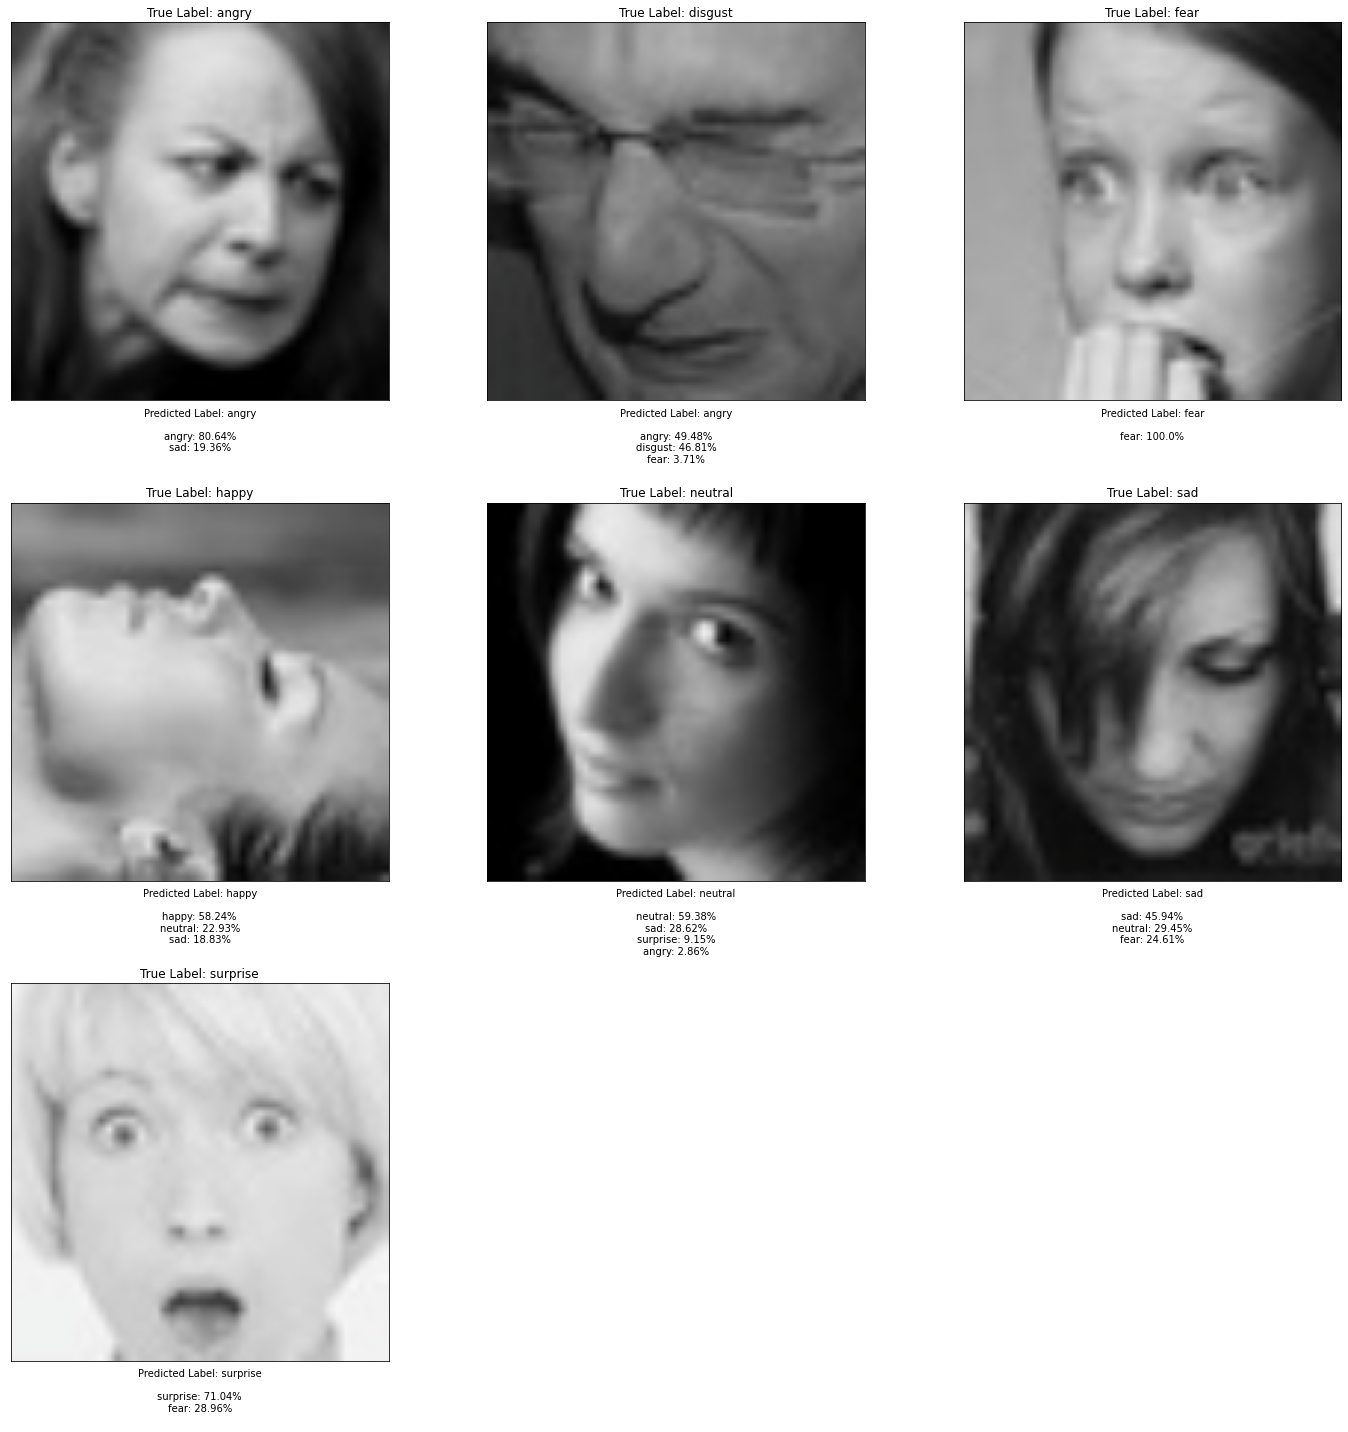

In [56]:
show_samples(inputs, true_labels, pred_fractions, pred_labels)

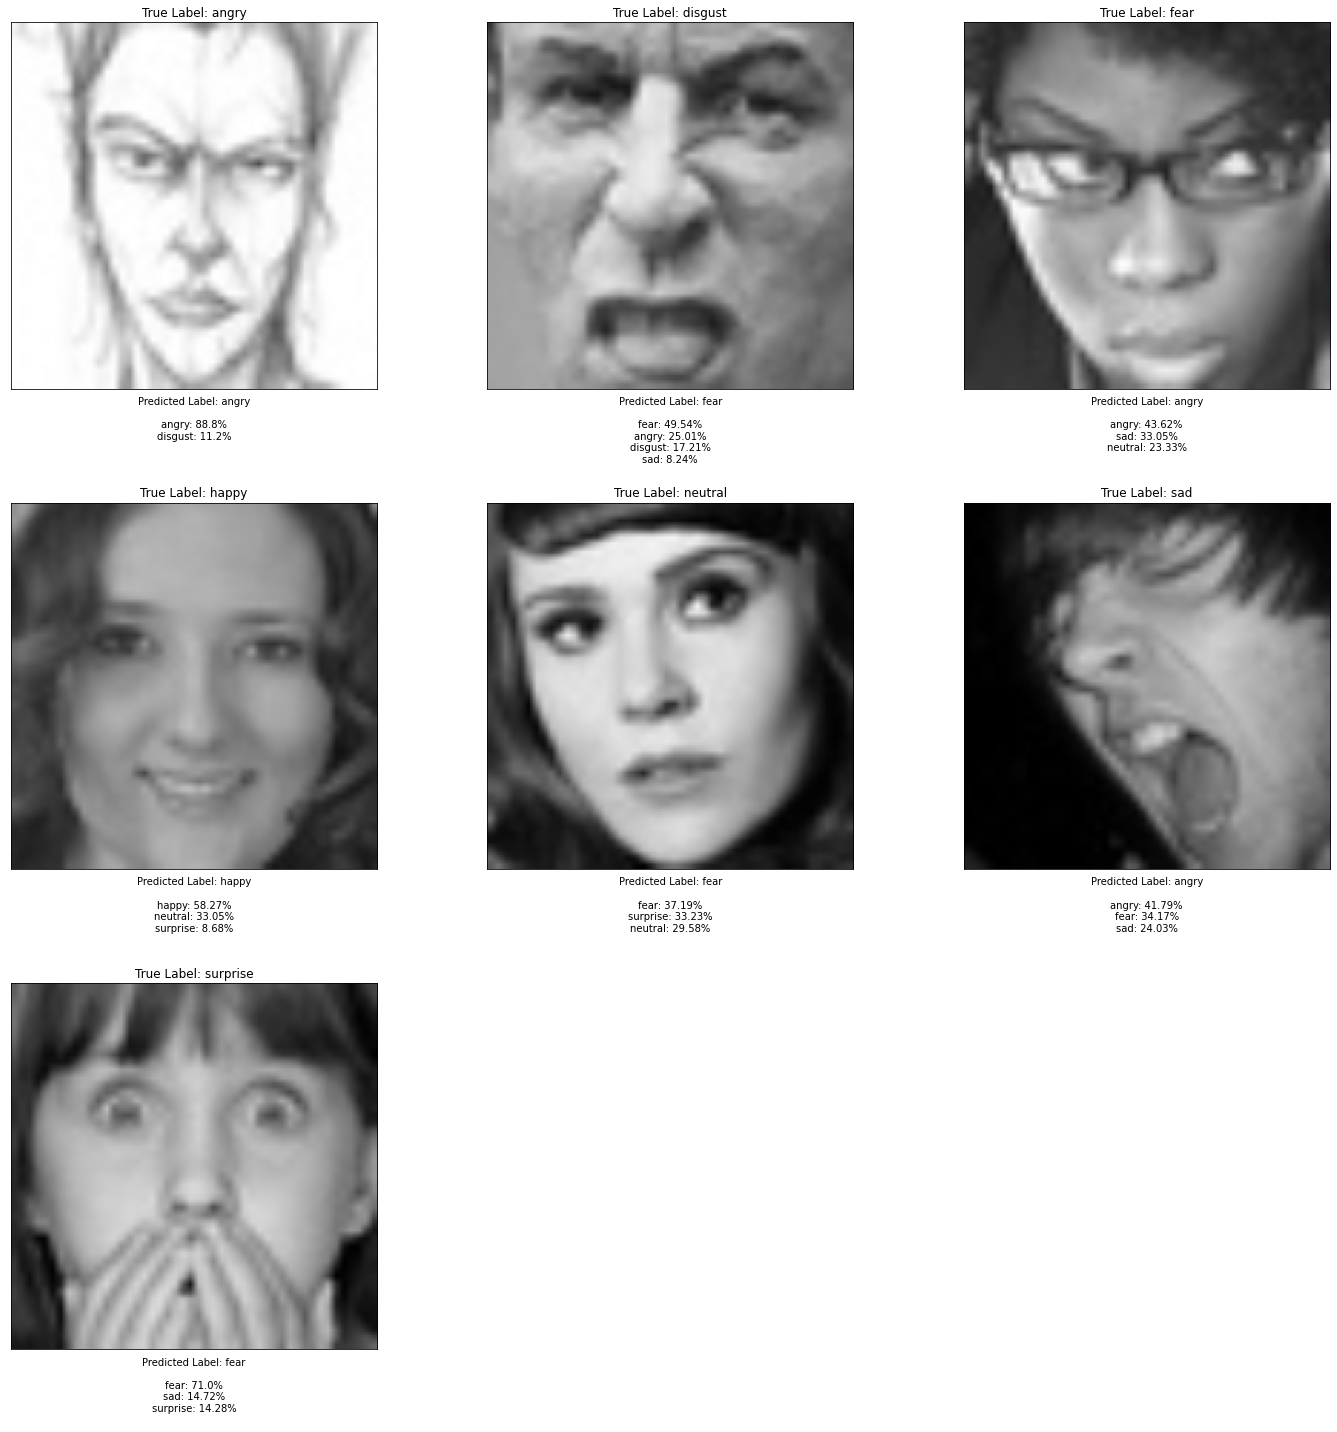

In [62]:
inputs, true_labels, pred_fractions, pred_labels = eval_sample_inputs(resnet_finetune3, test_loader, device, seed=10)
show_samples(inputs, true_labels, pred_fractions, pred_labels)

- data augmentation
- confusion matrix
- solve overfitting
- apply different models


final step:
- web deployment